# IMMUNE RESPONSE TO PNEUMOCCI

(Based on a final project submitted by Kazuki Fukumoto to BIOEN 599, March, 2024, University of Washington)

In [1]:
import controlSBML as ctl

import control
import numpy as np

# 1. Problem Statement & System Description

This model explores how the immune system responds to the infection of Pneumococci, which is the microbe associated with pneumonia. The model considers Pneumococci, susceptible epithelial cells, epithelial cells with bacteria, cytokines, neutrophils, and debris (apoptotic cellular material). The baseline simulation shows that Pneumococci are not eliminated, and all epithelial cells are eliminated. This is because the neutrophils are not produced and deployed fast enough to eliminate the infection. Even if enough neutrophils are produced, large overshoots or oscillations of neutrophils could be the factor of other health problems. To overcome these problems, I set two following control objectives.

We have two control objectives.

- Control objective 1: shortening settling time so that neutrophils [N] increases fast enought to eliminate Pneumococci [P]
- Control objective 2: having no or small overshoot of neutrophils

In this design, shorter time to reach the setpoint, small overshoot of [N], and zero or negative [P] are the goal to achive. Negative [P] doesn't make sence physically, but in this case, negative [P] is good because it indicates the elimination of P. In terms of setpoint, it is based on the maximum conc. of N with the original open loop simulation. 

The design can increase [N] quickly, and [N] reaches the setpoint. Increasing kP shortens the time to reach the setpoint. Increasing kI makes the amplitude of increase smaller, and [P] is not eliminated. Therefore, kP would be more important to achive my control objective.

## System Exploration

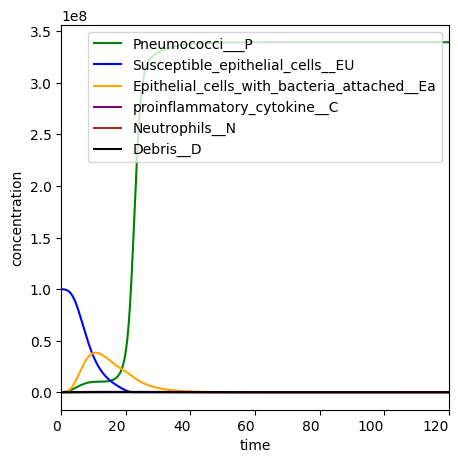

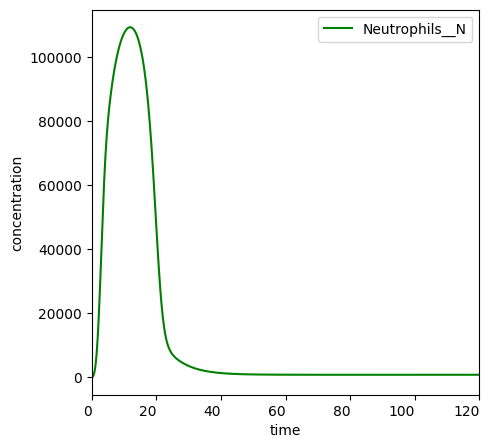

In [2]:
URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL1808280007/6/Smith2011_V1.xml"
TIMES = np.linspace(0, 120, 1200)
FIGSIZE = (5, 5)
CTLSB = ctl.ControlSBML(URL, times=TIMES, is_fixed_input_species=True, figsize=FIGSIZE)
_ = CTLSB.plotModel()
_ = CTLSB.plotModel(selections=["Neutrophils__N"])

## System Definition

We want to explore the effect of the titers of Pneumocci on netrophils.

In [3]:
INPUT_NAME = 'Pneumococci___P'
OUTPUT_NAME = 'Neutrophils__N'

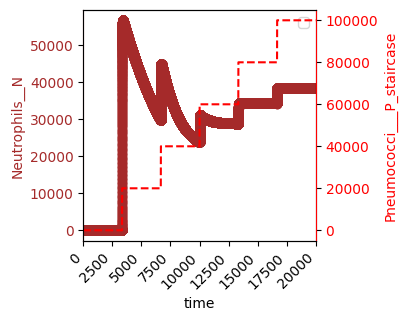

In [4]:
CTLSB = ctl.ControlSBML(URL, input_name=INPUT_NAME, output_name=OUTPUT_NAME, is_fixed_input_species=True,
                       figsize=FIGSIZE)
TIMES = np.linspace(0, 20000, 200000)
FINAL_VALUE = 100000
_ = CTLSB.plotStaircaseResponse(initial_value = 0, final_value=FINAL_VALUE, num_step=5, 
                                                    times=TIMES, figsize=(3,3), xlabel_angle=45)

We see that there is an initial transient and that a sufficiently long time is required to see the response to Pneumocci titers. A longer time horizon is needed to demonstrate the effect of the control input.

# 2. System Identification

In [5]:
FIT_START_TIME = 10000
FIT_END_TIME = TIMES[-1]

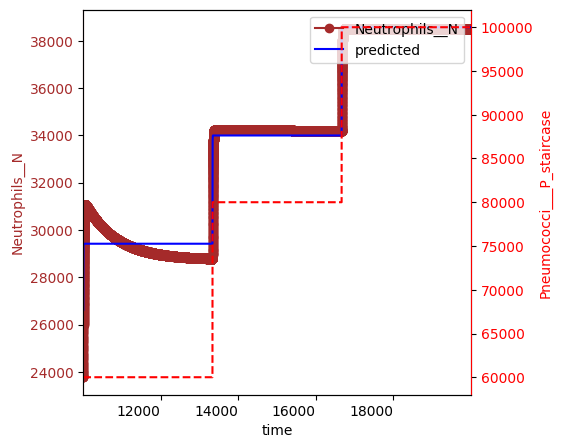

In [6]:
result = CTLSB.plotTransferFunctionFit(times=TIMES, initial_value=10, final_value=FINAL_VALUE,
        fit_start_time=FIT_START_TIME, fit_end_time=FIT_END_TIME,
        num_zero=0, num_pole=2, fitter_method="gpz")

In [7]:
TRANSFER_FUNCTION = CTLSB.getOpenLoopTransferFunction()
TRANSFER_FUNCTION

TransferFunction(array([0.22887252]), array([0.31748021, 1.78740105, 1.        ]))

In [8]:
print("poles: ", TRANSFER_FUNCTION.poles())
print("zeros: ", TRANSFER_FUNCTION.zeros())
print("DCgain: ", TRANSFER_FUNCTION.dcgain())

poles:  [-5.        +0.j -0.62996052+0.j]
zeros:  []
DCgain:  0.22887252099188843


This isn't a bad fit over the region of interest.

# 3. Control Design

## Testbed Construction

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


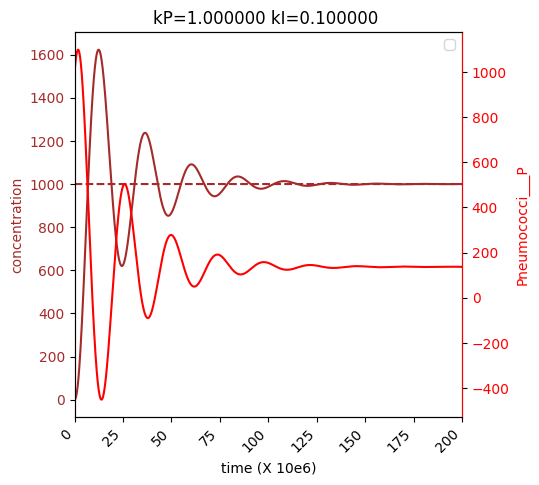

In [9]:
TIMES = times=np.linspace(0, 200, 2000)
SETPOINT = 1000
_ = CTLSB.plotDesign(kP_spec=1.0, kI_spec=0.1, times=TIMES, xlabel_angle=45, setpoint=SETPOINT, xlabel="time (X 10e6)")

We have a massive overshoot and a very long settling time.

## Loot Rocus Analysis

We plan to use PI control. So, we do the root locus analysis for I-control to see the effect of the parameter $k_I$.

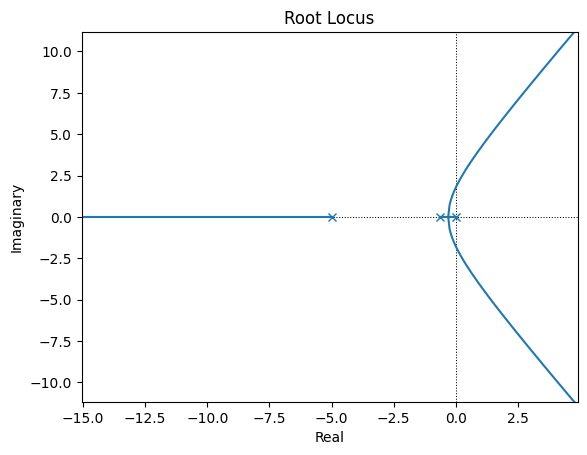

In [10]:
s = control.TransferFunction.s
_ = control.root_locus(TRANSFER_FUNCTION/s, grid=False)

The open loop poles are negative, but with PI control, we add a pole at zero. We see $k_I$ should be small so that we move it away from 0 (towards a more negative value). But we don't want $k_I$ so large that we pass the breakaway point (since this will introduce oscillations and make the real part of the pole closer to 0).

## Grid Search

By using PI control, we converge to the setpoint. With the grid search, we find design parameters that greatly reduce oscillations. 

100%|██████████| 100/100 [00:04<00:00, 23.69it/s]


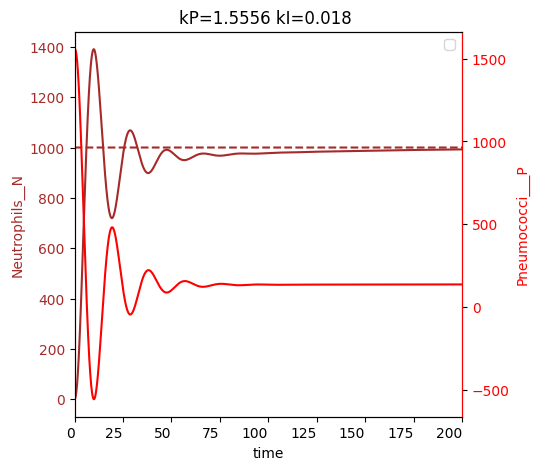

In [11]:
grid = CTLSB.getGrid()
grid.addAxis("kP", min_value=0.5, max_value=10, num_coordinate=10)
grid.addAxis("kI", min_value=0.002, max_value=0.02, num_coordinate=10)
design_result = CTLSB.plotGridDesign(grid, times=TIMES, setpoint=SETPOINT)

We show that these results are robust to the choice of setpoint.

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


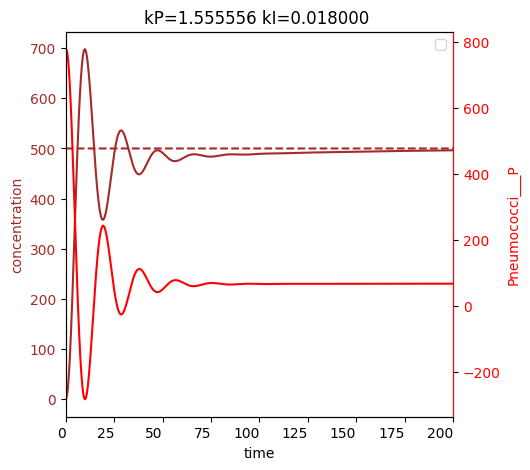

In [31]:
_ = CTLSB.plotDesign(kP_spec=CTLSB.kP, kI_spec=CTLSB.kI, times=TIMES, setpoint=0.5*SETPOINT)

# 4. Perturbations

## Model of Perturbations

A perturbation is an unknown and undesired signal injected into the closed loop system. There are two types. A disturbance perturbation is added to the control input before it is applied to the open loop system. A noise perturnbation is to the measured output before it is available to the closed loop system. These have slight different effects.

Our model for these undesired signals constants of several parts: a sinusoid, a random variable from a lognormal distribution (which is always non-negative), and a constant. This is formalized as
$$M exp^{N(0, \sigma)} + A sin(F t) + T t + C$$,
where
* $M$ is magnitude of the random noise
* $\sigma$ is standard deviation of the random noise
* $A$ is amplitude of the sine wave
* $F$ is frequency of the sine wave
* $T$  is multiplier of a ramp
* $C$ is a constant
* $t$ is time

## Noise Perturbation

We start by considering a modest level of lognormal noise. Both the magnitude of the noise (``random_mag``) and its standard deviation (``random_std``) impact the difficulty of closed loop design.

In [13]:
%%time
noise_spec = ctl.NoiseSpec(random_mag=1, random_std=0.1)
ctlsb = ctl.ControlSBML(URL, times=TIMES, is_fixed_input_species=True, figsize=FIGSIZE,
                       input_name=INPUT_NAME, output_name=OUTPUT_NAME, noise_spec=noise_spec)
grid = ctlsb.getGrid()
grid.addAxis("kP", min_value=0.5, max_value=10, num_coordinate=10)
grid.addAxis("kI", min_value=0.0, max_value=0.02, num_coordinate=10)
grid.addAxis("kD", min_value=0.0, max_value=0.02, num_coordinate=10)
grid.addAxis("kF", min_value=0.0, max_value=10, num_coordinate=10)
if False:
    # This takes several hours to run
    design_result = ctlsb.plotGridDesign(grid, times=TIMES, setpoint=SETPOINT, num_restart=5)

CPU times: user 169 ms, sys: 42.8 ms, total: 212 ms
Wall time: 1.27 s


<img src="https://github.com/ModelEngineering/controlSBML/raw/main/docs/images/pneumocci_design_output.png" alt="drawing" width="600"/>


We can still control this system with a slightly larger standard deviation.

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.01s/it]


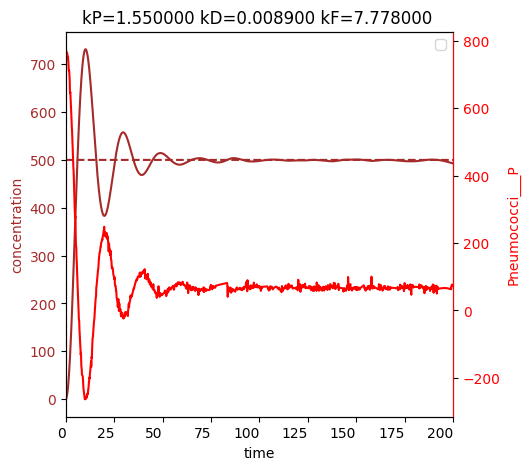

In [32]:
noise_spec = ctl.NoiseSpec(random_mag=1.0, random_std=0.3, offset=1)
ctlsb = ctl.ControlSBML(URL, times=TIMES, is_fixed_input_species=True, figsize=FIGSIZE,
                       input_name=INPUT_NAME, output_name=OUTPUT_NAME, noise_spec=noise_spec)
_ = ctlsb.plotDesign(kP_spec=1.55, kF_spec=7.778, kD_spec=0.0089, setpoint=500) 

However, a large increase in standard deviation makes the system difficult to control

In [33]:
noise_spec = ctl.NoiseSpec(random_mag=1.0, random_std=1, offset=1)
ctlsb = ctl.ControlSBML(URL, times=TIMES, is_fixed_input_species=True, figsize=FIGSIZE,
                       input_name=INPUT_NAME, output_name=OUTPUT_NAME, noise_spec=noise_spec)
_ = ctlsb.plotDesign(kP_spec=1.55, kF_spec=7.778, kD_spec=0.0089, setpoint=500) 

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.15s/it]


CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)


Error: CVODE Error: CV_CONV_FAILURE, Module: CVODES, Function: CVode, Message: At t = 0.00326498 and h = 2.83529e-13, the corrector convergence test failed repeatedly or with |h| = hmin.
/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** System is unstable for kP=1.55, kI=None, kD=0.0089, kF=7.778



To understand the underlying issues, we use a shorter time course to observe the system trajectory.

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.87s/it]


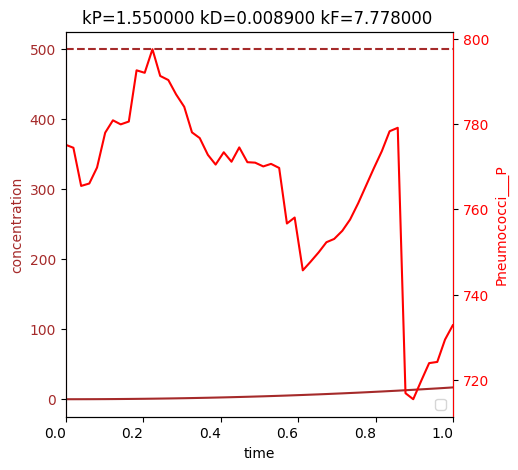

In [35]:
noise_spec = ctl.NoiseSpec(random_mag=1.0, random_std=1, offset=1)
ctlsb = ctl.ControlSBML(URL, times=np.linspace(0, 1, 50), is_fixed_input_species=True, figsize=FIGSIZE,
                       input_name=INPUT_NAME, output_name=OUTPUT_NAME, noise_spec=noise_spec)
_ = ctlsb.plotDesign(kP_spec=1.55, kF_spec=7.778, kD_spec=0.0089, setpoint=500) 

Compare this to a system without noise.

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


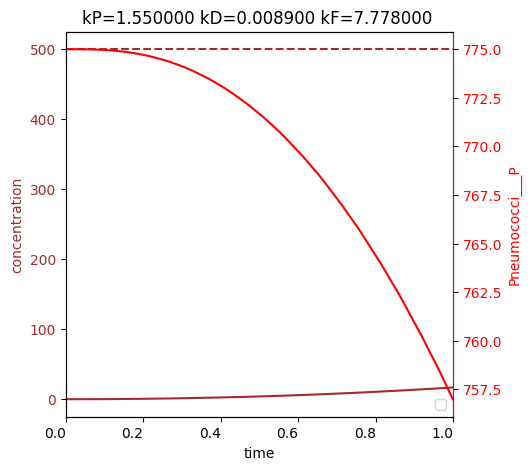

In [36]:
ctlsb = ctl.ControlSBML(URL, times=np.linspace(0, 1, 50), is_fixed_input_species=True, figsize=FIGSIZE,
                       input_name=INPUT_NAME, output_name=OUTPUT_NAME)
_ = ctlsb.plotDesign(kP_spec=1.55, kF_spec=7.778, kD_spec=0.0089, setpoint=500) 

In [ ]:
Note that the input is controlled to a smooth trajectory if there is no noise, and so effective feedback can be
constructed. This is in contrast to a situation with much moise.

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.84s/it]


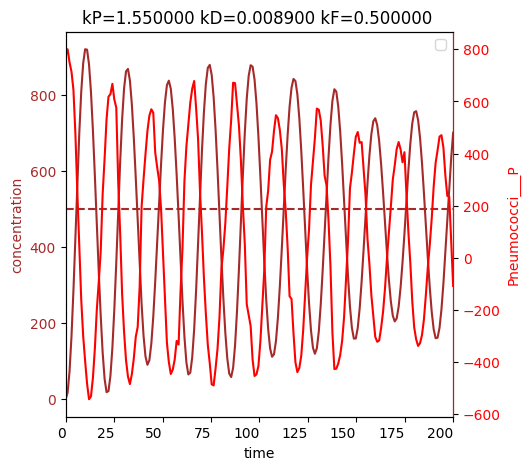

In [66]:
noise_spec = ctl.NoiseSpec(random_mag=1.0, random_std=1, offset=1)
ctlsb = ctl.ControlSBML(URL, times=np.linspace(0, 200, 200), is_fixed_input_species=True, figsize=FIGSIZE,
                       input_name=INPUT_NAME, output_name=OUTPUT_NAME, noise_spec=noise_spec)
_ = ctlsb.plotDesign(kP_spec=1.55, kF_spec=0.5,kD_spec=0.0089, setpoint=500) 

By filtering more aggressively ($k_F$ is smaller), we reduce the effect of noise. Note that $k_D$ plays an important role by detecting trends in the filtering and counteracting them.

## Disturbance Perturbation

Here, we inject a perturbation as a disturbance instead of noise. We use a disturbance that is 1/10 the magnitude and standard deviation as we used with noise in order to be controllable with out design parameters.

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


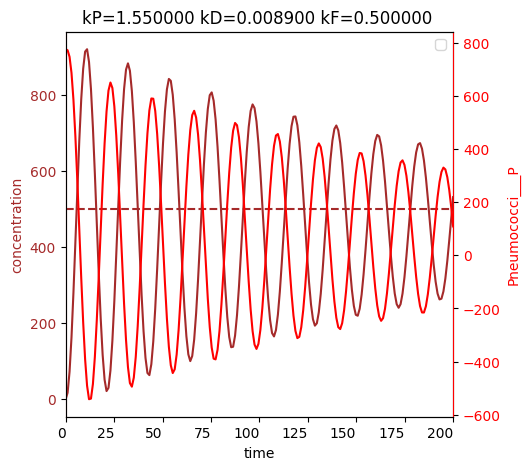

In [93]:
disturbance_spec = ctl.NoiseSpec(random_mag=0.1, random_std=0.1, offset=1)
ctlsb = ctl.ControlSBML(URL, times=np.linspace(0, 200, 200), is_fixed_input_species=True, figsize=FIGSIZE,
                       input_name=INPUT_NAME, output_name=OUTPUT_NAME, disturbance_spec=disturbance_spec)
_ = ctlsb.plotDesign(kP_spec=1.55, kF_spec=0.5,kD_spec=0.0089, setpoint=500) 